# The Quasi-Stokes Problem

The Quasi-Stokes problem may arise as sub-problem in a numerical
scheme for the time-dependent Navier-Stokes equations where all
non-linear and asymmetric contributions are just "shifted" to the
"right-hand-side", evaluating the solution from the previous
time-step.

In the following the notations from the Navier-Stokes intro are
used. Please make sure that you have that at hand.

## Setting of the problem

We consider a tube or canal with an inflow-boundary with prescibed
values of the velocity and an outflow boundary where we impose
zero-stress conditions. On the "wall" of the tube or canal no-slip
(i.e. Dirichlet zero) boundary conditions are asserted.

The problem thus reads:

\begin{align*}
\rho\,u  - \nabla \cdot \sigma (u, p) &= 0\quad\text{ in }\Omega,\\
\nabla \cdot u &= 0\quad\text{ in }\Omega,\\
u &= 0\text{ on }\Gamma_\mathrm{noslip},\\
u &= g\text{ on }\Gamma_\mathrm{inflow},\\
\sigma(u,\,p)\,n &= 0\text{ on }\Gamma_\mathrm{stress}\\
\end{align*}

on the domain $\Omega=(0,\,8)\times(-1,1)$. The boundary of $\Omega$ is thus split into
the following parts

- $\Gamma_\mathrm{noslip} = (0,\,8)\times\{-1,\,1\}$
- $\Gamma_\mathrm{inflow} = \{0\}\times(-1,\,1)$
- $\Gamma_\mathrm{stress} = \{8\}\times(-1,\,1)$

For the inflow conditions we assume a parabolic profile which is
zero at the walls of the channel. Please feel free to play around
with this. Example:

$$
g(x,\,y) = \mathrm{inflowStrength}\,(1-y)\,(1+y)\,\left(\begin{matrix} 1\\ 0\end{matrix}\right)
$$

with "$\mathrm{inflowStrength}$" being some unimportant constant. Do not
choose it too large. Do not bother me. Choose it to be $1$ if in
doubt (but feel free to play with it).

If you stick to this example you get a parabolic inflow profile
pointing to the positive $x$-axis.

With all these settings, the variational formulation is the
following:

\begin{align*}
\int_\Omega \rho\,u\cdot v + \sigma(u,\,p):\varepsilon(v)\,\mathrm{d}x & = 0\\
\int_\Omega \nabla\cdot u\,q\,\mathrm{d}x &= 0,
\end{align*}

If you compare this formulation with the Navier-Stokes intro you
will find that the not-well-defined boundary integrals are no
longer there; they have been replaced by the zero-stress condition
on $\Gamma_\mathrm{stress}$ and were "annihilated" by the
test-functions (zero on the no-slip boundaries) on $\Gamma_\mathrm{noslip}$ and $\Gamma_\mathrm{inflow}$.

Programmatically, the Dirichlet conditions have to be implemeneted
just in the same manner as before, while on the outflow ("stress") boundary we just
have "do nothing", "natural" boundary conditions.

In [1]:
# import stuff

from matplotlib import pyplot
from ufl import (
    TestFunction,
    TrialFunction,
    SpatialCoordinate,
    FacetNormal,
    Identity,
    dx,
    ds,
    div,
    grad,
    sym,
    nabla_grad,
    dot,
    inner,
    conditional,
    as_vector,
)
from dune.ufl import Constant, DirichletBC, cell
import numpy as np
import dune
import dune.fem as fem
from dune.grid import cartesianDomain
from dune.grid import Marker
from dune.alugrid import aluConformGrid as leafGridView
from dune.fem.space import lagrange, composite
from dune.fem.scheme import galerkin as solutionScheme
from dune.fem.function import gridFunction

# use threading to utilize more cores
# fem.threading.use = 8 # or simply call
fem.threading.useMax()

Define the computational domain and the grid-view

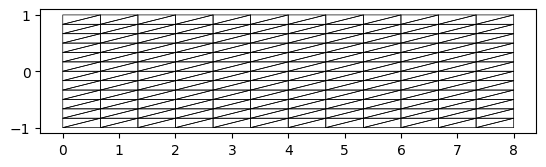

In [2]:
##### TASK
domain = cartesianDomain([0, -1], [8, 1], [12, 12])
gridView = leafGridView(domain)
gridView.plot()

Define the discrete spaces

In [3]:
# dimension of the grid
dim = gridView.dimension

polynomialOrder = 2

# velocity space (vector valued)
V = lagrange(gridView, order=polynomialOrder, dimRange=dim)

# pressure space
Q = lagrange(gridView, order=polynomialOrder - 1)

# In this simple approach we just "virtually" combine both spaces into
# one in order to be able to just pass it to the solver. "Taylor-Hood"
# element denotes a pair of spaces for the velocity and the pressure
# where the polynomial degree of the pressure space is one less than
# the polynomial degree of the velocity space.
#
compositeTaylorHoodSpace = composite(V, Q, components=["velocity", "pressure"])

U = TrialFunction(compositeTaylorHoodSpace)
V = TestFunction(compositeTaylorHoodSpace)
x = SpatialCoordinate(compositeTaylorHoodSpace)
# ... and in order to gain again access to the velocity and pressure
# as individual functions we define the following
# short-cuts. Obviously, when switching to 3d this has to be adjusted accordingly
# TODO: write this as a general expression for arbitrary dimension
u = as_vector([U[0], U[1]])
v = as_vector([V[0], V[1]])
p = U[dim]
q = V[dim]

# kinematic viscosity
mu  = Constant(1, "mu")

# mass density
rho = Constant(1, "rho")

# inflow strength
inflowStrength = Constant(1.0, "inflowStrength")

define the inflow values as grid-function

In [4]:
##### TASK

DUNE-INFO: UFLLocalFunction (rebuilding)


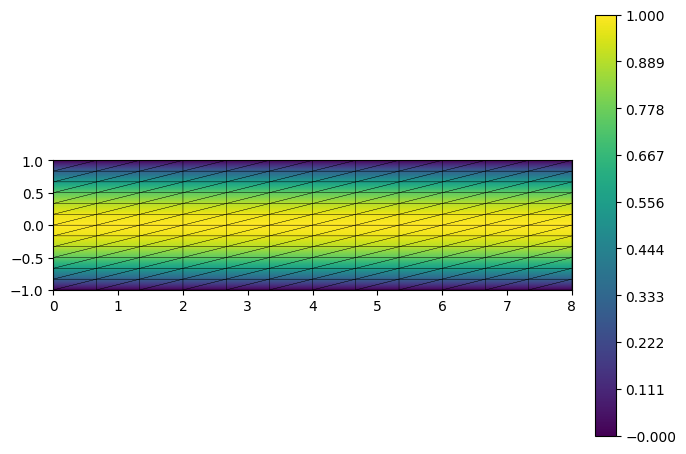

In [5]:
# @gridFunction(gridView=gridView, name="inflow", order = 1)
# def inflow(x):
#     return dune.common.FieldVector([inflowStrength*(1-x[1])*(1+x[1]), 0.0])
# inflow.plot()

inflow = gridFunction(as_vector([inflowStrength*(1-x[1])*(1+x[1]), 0.0]), gridView)
inflow.plot()

Define the Dirichlet b.c.

In [6]:
##### TASK
no_slip_top = DirichletBC(compositeTaylorHoodSpace, [0, 0, None], x[1] > 1 - 1e-10)
no_slip_bottom = DirichletBC(compositeTaylorHoodSpace, [0, 0, None], x[1] < -1 + 1e-10)
inflow_boundary = DirichletBC(compositeTaylorHoodSpace, [inflow[0], inflow[1],None], x[0] < 1e-10)


Define the strain-rate tensor `epsilon(u)`, the stress tensor
`sigma(u,p)` and use these two to define the UFL form
`quasiStokesForm` which describes the problem.

In [7]:
##### TASK
epsilon = lambda w:  1/2*(nabla_grad(w) + nabla_grad(w).T)
sigma = -p*Identity(dim) + 2*mu*epsilon(u)

In [8]:

quasi_stokes = rho*dot(u, v)*dx + inner(sigma, epsilon(v))*dx + div(u)*q*dx

Initialize the scheme and call the solver. Note that the matrix is
not positive definite and ill conditioned. Refer the the talk about
solvers and solver parameters in order to be able to tune the
iterative solver.

In [9]:
##### TASK

In [10]:
scheme = solutionScheme([quasi_stokes == 0, no_slip_top, no_slip_bottom, inflow_boundary], solver = "gmres")

DUNE-INFO: Integrands (rebuilding)
DUNE-INFO: Scheme (rebuilding)


KeyboardInterrupt: 

Solve several times with global refinement. To this aim use a
marking function which simply marks all elements and take care that
U_h is also carried over to the finer grid.

In [ ]:
##### TASK
# solution = compositeTaylorHoodSpace.interpolate([0]*3, name="solution")
solution = compositeTaylorHoodSpace.function(name="solution")

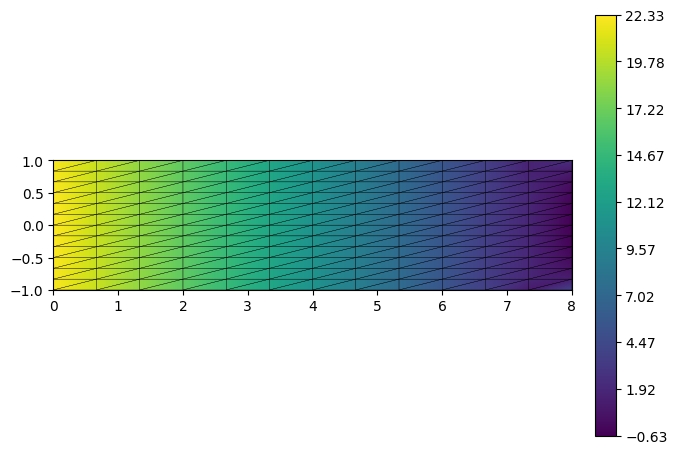

In [ ]:
scheme.solve(target=solution)
solution[2].plot()

In [ ]:
print("finished")

finished


## Further tasks

- Refine the mesh globally and solve on a finer mesh!

- Make the viscosity smaller or the inflow strength larger and observe the effects!

- Add a non-zero force! What happens? Does it affect the velocity? Does it affect the pressure?

- Replace the grid generation by using an initial triangulation defined by a suitable DGF file!

- Using this DGF file replace the geometric boundary classification by boundary ids!

- Dig a square hole into the channel, impose no-slip conditions there and solve again!

- In order to have some more interesting grids: make the hole a round circle!
  (have a look at the provided example DGF files)

- try to use gmsh to construct a mesh with a hole (see the "adaptivity" lecture)

- Write out the solution as VTK data and observe the results in Paraview

- Convert this code -- which in parts is dimension dependent -- into dimension independent code and run a similar example in 3d!